# **Suite** : Ingénierie des caractéristiques

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

# Chargement des données pré-nettoyées (output de l'EDA)
data_path = Path("C:/Users/Optimiste/Videos/Concours/Prédiction_prix_plaques_russes/data")
train = pd.read_csv(data_path / "train_eda.csv") 
test = pd.read_csv(data_path / "test_eda.csv")

In [7]:
# Aperçu
print(train.shape)
print(train.head())

(51635, 13)
   id      plate                 date   price letters  digits  region_code  \
0   1  X059CP797  2024-12-26 00:00:00   65000     XCP      59          797   
1   2  Y800MH790  2024-07-12 21:31:37  100000     YMH     800          790   
2   3   A212TX77  2024-04-18 00:00:00  290000     ATX     212           77   
3   4  P001AY199  2025-01-03 00:27:15  680000     PAY       1          199   
4   5  P001AY199  2025-01-10 09:32:41  750000     PAY       1          199   

     region_name  is_gov_plate  has_road_advantage  gov_importance_level  \
0         Moscow             0                   0                     0   
1  Moscow Oblast             0                   0                     0   
2         Moscow             0                   0                     0   
3         Moscow             0                   0                     0   
4         Moscow             0                   0                     0   

     month  is_magic  
0  2024-12         0  
1  2024-07      

**Préparation des Données**

In [10]:
# -------------------------------------------------------------------
# 1. Vérification et Nettoyage Initial
# -------------------------------------------------------------------
def check_data(df, name):
    print(f"\n{name} - Dimensions: {df.shape}")
    print("Variables:", df.columns.tolist())
    print("Valeurs manquantes:\n", df.isnull().sum())
    print("Exemples:\n", df.head(2))

check_data(train, "Train")
check_data(test, "Test")


Train - Dimensions: (51635, 13)
Variables: ['id', 'plate', 'date', 'price', 'letters', 'digits', 'region_code', 'region_name', 'is_gov_plate', 'has_road_advantage', 'gov_importance_level', 'month', 'is_magic']
Valeurs manquantes:
 id                      0
plate                   0
date                    0
price                   0
letters                 0
digits                  0
region_code             0
region_name             0
is_gov_plate            0
has_road_advantage      0
gov_importance_level    0
month                   0
is_magic                0
dtype: int64
Exemples:
    id      plate                 date   price letters  digits  region_code  \
0   1  X059CP797  2024-12-26 00:00:00   65000     XCP      59          797   
1   2  Y800MH790  2024-07-12 21:31:37  100000     YMH     800          790   

     region_name  is_gov_plate  has_road_advantage  gov_importance_level  \
0         Moscow             0                   0                     0   
1  Moscow Oblast   

In [12]:
# -------------------------------------------------------------------
# 2. Feature Engineering de Base (Appliqué aux deux datasets)
# -------------------------------------------------------------------
def basic_feature_engineering(df):
    # Conversion des dates
    df['date'] = pd.to_datetime(df['date'])
    
    # Extraction des composantes temporelles
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek  # 0=Lundi
    
    # Segmentation des plaques
    df['plate_prefix'] = df['letters'].str[:1]  # Première lettre
    df['plate_suffix'] = df['letters'].str[-1:] # Dernière lettre
    
    # Valeurs numériques symboliques
    df['is_angel_number'] = df['digits'].astype(str).apply(
        lambda x: 1 if len(set(x)) == 1 else 0)  # Ex: 111, 777
    
    return df

train = basic_feature_engineering(train)
test = basic_feature_engineering(test)


**Analyse par Information Mutuelle (MI)**

Features analysées: ['digits', 'region_code', 'is_gov_plate', 'has_road_advantage', 'gov_importance_level', 'is_magic', 'year', 'month', 'day_of_week', 'is_angel_number']


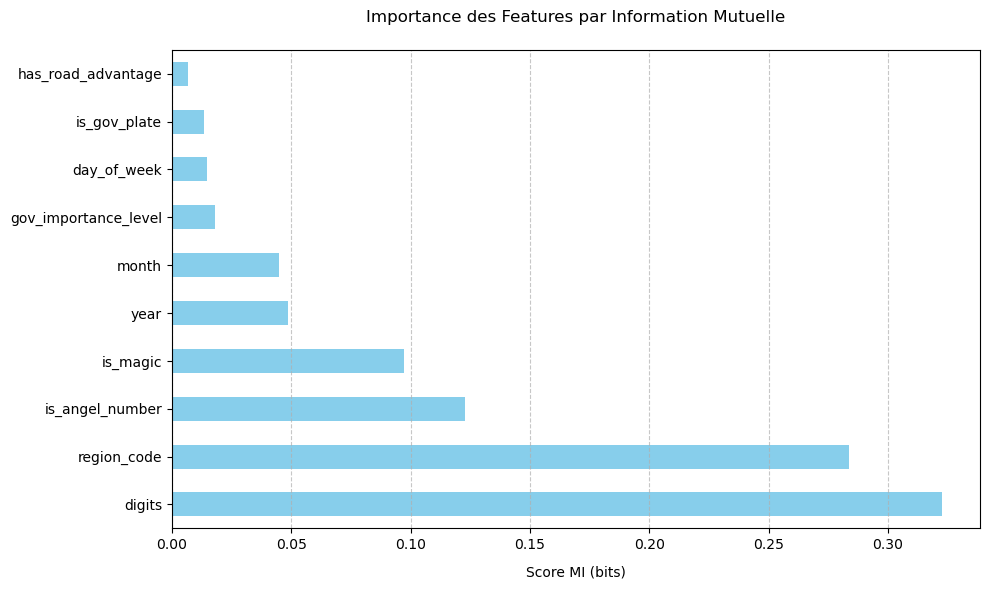


Top 5 Features Prédictives:
digits             0.322365
region_code        0.283688
is_angel_number    0.122583
is_magic           0.097057
year               0.048543
Name: MI, dtype: float64

Bottom 5 Features Peu Informatives:
month                   0.045046
gov_importance_level    0.018098
day_of_week             0.014891
is_gov_plate            0.013511
has_road_advantage      0.006805
Name: MI, dtype: float64

Suggestions:
- Features à conserver/approfondir: ['digits', 'region_code', 'is_angel_number']
- Features potentiellement à supprimer: ['day_of_week', 'is_gov_plate', 'has_road_advantage']


In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Préparation des Features pour l'Analyse MI
# -------------------------------------------------------------------
# Liste des features candidates (numériques/encodées)
features = [
    'digits', 'region_code', 'is_gov_plate', 
    'has_road_advantage', 'gov_importance_level',
    'is_magic', 'year', 'month', 'day_of_week',
    'is_angel_number', 'letters_encoded', 
    'region_name_encoded', 'plate_prefix_encoded',
    'plate_suffix_encoded'
]

# Vérification de la disponibilité des features
available_features = [f for f in features if f in train.columns]
print("Features analysées:", available_features)

# -------------------------------------------------------------------
# 2. Calcul de l'Information Mutuelle
# -------------------------------------------------------------------
X = train[available_features]
y = train['price']  # Cible numérique

# Calcul MI (adapté aux variables mixtes)
mi_scores = mutual_info_regression(X, y, random_state=42, n_neighbors=3)
mi_scores = pd.Series(mi_scores, index=available_features, name="MI")
mi_scores = mi_scores.sort_values(ascending=False)

# -------------------------------------------------------------------
# 3. Visualisation des Résultats
# -------------------------------------------------------------------
plt.figure(figsize=(10, 6))
mi_scores.plot.barh(color='skyblue')
plt.title("Importance des Features par Information Mutuelle", pad=20)
plt.xlabel("Score MI (bits)", labelpad=10)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 4. Interprétation Stratégique
# -------------------------------------------------------------------
print("\nTop 5 Features Prédictives:")
print(mi_scores.head(5))

print("\nBottom 5 Features Peu Informatives:")
print(mi_scores.tail(5))

# Suggestions d'actions basées sur les résultats
suggestions = {
    'high_mi': mi_scores.index[:3].tolist(),
    'low_mi': mi_scores.index[-3:].tolist()
}
print("\nSuggestions:")
print(f"- Features à conserver/approfondir: {suggestions['high_mi']}")
print(f"- Features potentiellement à supprimer: {suggestions['low_mi']}")

**Feature Engineering Ciblé Basé sur l'Information Mutuelle**

In [18]:
# Extraction de motifs avancés
train['digit_sum'] = train['digits'].apply(lambda x: sum(int(d) for d in str(x)))
train['digit_product'] = train['digits'].apply(lambda x: np.prod([int(d) for d in str(x)]))
train['is_palindrome'] = train['digits'].astype(str).apply(lambda x: 1 if x == x[::-1] else 0)

# Segmentation numérique
def digit_category(x):
    x = str(x)
    if len(set(x)) == 1: return 'triple'  # 111, 777
    if x in ['123', '456', '789']: return 'sequential'
    if int(x) in range(100, 200): return '100s'
    return 'other'

train['digit_category'] = train['digits'].apply(digit_category)

In [20]:
# Extraction de motifs avancés
test['digit_sum'] = test['digits'].apply(lambda x: sum(int(d) for d in str(x)))
test['digit_product'] = test['digits'].apply(lambda x: np.prod([int(d) for d in str(x)]))
test['is_palindrome'] = test['digits'].astype(str).apply(lambda x: 1 if x == x[::-1] else 0)

# Segmentation numérique
def digit_category(x):
    x = str(x)
    if len(set(x)) == 1: return 'triple'  # 111, 777
    if x in ['123', '456', '789']: return 'sequential'
    if int(x) in range(100, 200): return '100s'
    return 'other'

test['digit_category'] = test['digits'].apply(digit_category)

In [22]:
# Clustering géographique
region_premium = {
    77: 'moscow', 
    99: 'center', 
    78: 'spb',
    797: 'crimea'  # Exemple
}
train['region_tier'] = train['region_code'].map(region_premium).fillna('standard')

# Interaction avec digits
train['premium_region_x_digits'] = train['region_code'].isin([77, 99]).astype(int) * train['digits']

In [24]:
# Clustering géographique
region_premium = {
    77: 'moscow', 
    99: 'center', 
    78: 'spb',
    797: 'crimea'  # Exemple
}
test['region_tier'] = test['region_code'].map(region_premium).fillna('standard')

# Interaction avec digits
test['premium_region_x_digits'] = test['region_code'].isin([77, 99]).astype(int) * test['digits']

In [26]:
# Extension aux nombres porte-bonheur russes
lucky_numbers = [111, 222, 333, 777, 13, 7, 99]
train['is_lucky_number'] = train['digits'].isin(lucky_numbers).astype(int)

In [28]:
# Extension aux nombres porte-bonheur russes
lucky_numbers = [111, 222, 333, 777, 13, 7, 99]
test['is_lucky_number'] = test['digits'].isin(lucky_numbers).astype(int)

**Gestion des Features Peu Informatifs**

In [31]:
features_to_drop = ['day_of_week', 'is_gov_plate', 'has_road_advantage']
train = train.drop(columns=features_to_drop)
test = test.drop(columns=features_to_drop)

In [33]:
# Score de prestige alphanumérique
def prestige_score(row):
    letter_val = sum(ord(c) for c in row['letters'])  # Valeur ASCII
    digit_val = row['digits'] / 100
    return letter_val + digit_val

train['prestige_score'] = train.apply(prestige_score, axis=1)

In [35]:
# Score de prestige alphanumérique
def prestige_score(row):
    letter_val = sum(ord(c) for c in row['letters'])  # Valeur ASCII
    digit_val = row['digits'] / 100
    return letter_val + digit_val

test['prestige_score'] = test.apply(prestige_score, axis=1)

In [37]:
# Périodes fiscales russes
train['is_year_end'] = train['month'].isin([12, 1]).astype(int)

test['is_year_end'] = test['month'].isin([12, 1]).astype(int)

**Validation des Nouveaux Features**

In [40]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# 1. Encodage des variables catégorielles
cat_features = ['digit_category', 'region_tier']  # Vos variables catégorielles
for col in cat_features:
    le = LabelEncoder()
    train[col+'_encoded'] = le.fit_transform(train[col])

# 2. Liste des nouveaux features NUMÉRIQUES uniquement
new_numeric_features = [
    'digit_sum', 
    'digit_product', 
    'is_palindrome',
    'digit_category_encoded',  # Version encodée
    'premium_region_x_digits',
    'is_lucky_number',
    'prestige_score',
    'is_year_end',
    'region_tier_encoded'  # Version encodée
]

# 3. Vérification des types
print("\nVérification des types:")
print(train[new_numeric_features].dtypes)

# 4. Ré-analyse MI sur les données numériques
X_new = train[new_numeric_features]
mi_new = mutual_info_regression(X_new, train['price'])
mi_results = pd.Series(mi_new, index=new_numeric_features, name="New MI").sort_values(ascending=False)

# 5. Affichage des résultats
print("\nNouveaux scores MI:")
print(mi_results)


Vérification des types:
digit_sum                    int64
digit_product                int64
is_palindrome                int64
digit_category_encoded       int64
premium_region_x_digits      int64
is_lucky_number              int64
prestige_score             float64
is_year_end                  int64
region_tier_encoded          int64
dtype: object

Nouveaux scores MI:
digit_product              0.202926
prestige_score             0.142610
digit_category_encoded     0.130581
region_tier_encoded        0.123284
digit_sum                  0.106949
premium_region_x_digits    0.061067
is_lucky_number            0.049607
is_palindrome              0.041951
is_year_end                0.024251
Name: New MI, dtype: float64


In [68]:
# 1. Encodage des variables catégorielles
cat_features = ['digit_category', 'region_tier']  # Vos variables catégorielles
for col in cat_features:
    le = LabelEncoder()
    test[col+'_encoded'] = le.fit_transform(test[col])

---

## Feature Selection :

In [42]:
selected_features = mi_results[mi_results > 0.1].index.tolist()
print("\nFeatures à conserver:", selected_features)


Features à conserver: ['digit_product', 'prestige_score', 'digit_category_encoded', 'region_tier_encoded', 'digit_sum']


**Pipeline d'Encodage :**

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', LabelEncoder(), ['digit_category', 'region_tier']),
        ('num', 'passthrough', new_numeric_features)
    ])

**Visualisation :**

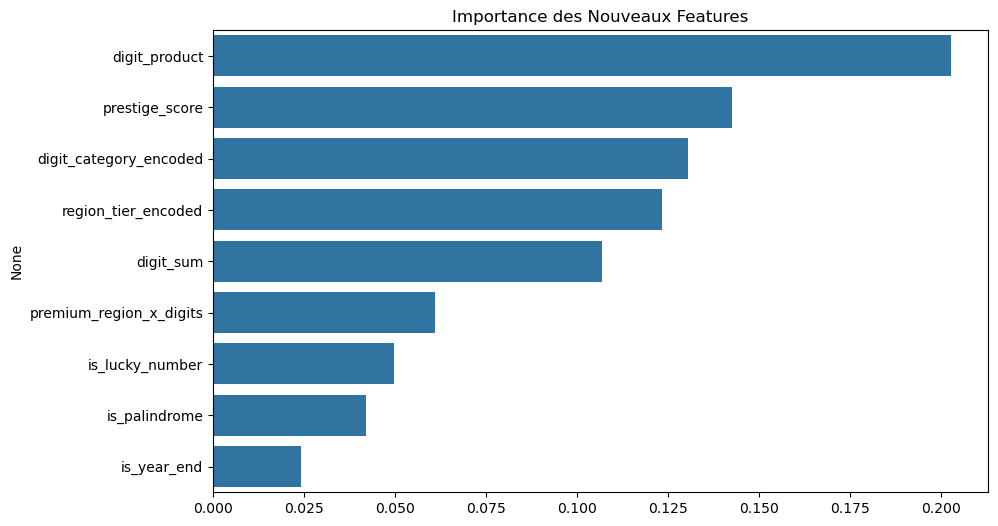

In [49]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=mi_results.values, y=mi_results.index)
plt.title("Importance des Nouveaux Features")
plt.show()

---
## Modélisation - Benchmark des Modèles et Stratégie de Soumission

In [53]:
final_features = [
    # Top features MI
    'digit_product',
    'prestige_score',
    'digit_category_encoded',
    'region_tier_encoded',
    'digit_sum',
    
    # Features de base conservés
    'digits',
    'region_code',
    'is_angel_number'
]

# Vérification
print("Dimensions finales:", train[final_features].shape)

Dimensions finales: (51635, 8)


In [55]:
# Option 1 : Utilisation de log(price)
train['log_price'] = np.log1p(train['price'])
y = train['log_price']  # Cible transformée

# Option 2 : Prix brut (à comparer)
# y = train['price']

# Features sélectionnées
X = train[final_features]

In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# 2. Définition des colonnes par type
numeric_features = [f for f in final_features if f in ['digit_product', 'prestige_score', 'digit_sum', 'digits', 'region_code']]
categorical_features = [f for f in final_features if f in ['digit_category_encoded', 'region_tier_encoded']]

# Configuration commune
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(loss='absolute_error', n_estimators=200),
    "XGBoost": XGBRegressor(objective='reg:absoluteerror', n_estimators=200),
    "LightGBM": LGBMRegressor(objective='mape', num_leaves=31, n_estimators=200)
}

**Benchmark avec Validation Croisée**

In [61]:
from sklearn.model_selection import cross_val_score
import numpy as np

results = {}
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X, y, cv=5, 
                           scoring='neg_mean_absolute_percentage_error')
    results[name] = {
        'MAPE': round(-scores.mean() * 100, 2),
        'Std': round(scores.std() * 100, 2)
    }

# Affichage des résultats
pd.DataFrame(results).T.sort_values('MAPE')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 41308, number of used features: 14
[LightGBM] [Info] Start training from score 11.918397


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 41308, number of used features: 14
[LightGBM] [Info] Start training from score 11.918397


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 41308, number of used features: 14
[LightGBM] [Info] Start training from score 11.918397


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 41308, number of used features: 14
[LightGBM] [Info] Start training from score 11.918397


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 41308, number of used features: 14
[LightGBM] [Info] Start training from score 11.918397


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,MAPE,Std
LightGBM,4.71,0.04
XGBoost,4.75,0.02
GradientBoosting,4.99,0.05
RandomForest,5.05,0.02


**Stratégie de Soumission**

In [70]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

# 1. Configuration Optimale
# final_features = [
#    'digit_product', 'prestige_score', 'digit_category_encoded',
#   'region_tier_encoded', 'digit_sum', 'digits', 'region_code'
# ]

# 2. Pipeline Commun
def create_pipeline(model):
    return make_pipeline(
        preprocessor,  # Votre ColumnTransformer existant
        model
    )

# 3. Modèles Optimisés
lgbm_params = {
    'objective': 'mape',
    'num_leaves': 127,  # Augmenté pour capturer plus de motifs
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 100,
    'force_row_wise': True,
    'verbosity': -1,
    'random_state': 42
}

xgb_params = {
    'objective': 'reg:absoluteerror',
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# 4. Fonction de Prédiction Améliorée
def train_predict_submit(models_dict):
    for name, model in models_dict.items():
        # Entraînement
        pipeline = create_pipeline(model)
        pipeline.fit(train[final_features], train['log_price'])
        
        # Prédiction avec conversion
        preds = np.expm1(pipeline.predict(test[final_features]))
        
        # Post-traitement (clip des valeurs extrêmes)
        q99 = np.quantile(preds, 0.99)
        preds = np.clip(preds, 0, q99)
        
        # Sauvegarde
        pd.DataFrame({'id': test['id'], 'price': preds})\
          .to_csv(f'submission_{name}.csv', index=False)
        print(f"Soumission {name} sauvegardée (Prix min/max: {preds.min():.0f}-{preds.max():.0f} RUB)")

# 5. Modèles à Soumettre
models_to_submit = {
    'lgbm_optim': LGBMRegressor(**lgbm_params),
    'stack_lgbm_xgb': StackingRegressor(
        estimators=[
            ('lgbm', LGBMRegressor(**lgbm_params)),
            ('xgb', XGBRegressor(**xgb_params))
        ],
        final_estimator=LGBMRegressor(n_estimators=50, verbose=-1)
    )
}

# 6. Exécution
train_predict_submit(models_to_submit)

C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Soumission lgbm_optim sauvegardée (Prix min/max: 46020-933408 RUB)


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but L

Soumission stack_lgbm_xgb sauvegardée (Prix min/max: 49009-1287099 RUB)


C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Optimiste\.conda\envs\kaggle_plates\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
